# LQG with nonlinear simulation
## Cart Pole dynamics

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    import google.colab
    IN_COLAB = True
    # don't need serial here
except:
    IN_COLAB = False
    try: 
        import serial
    except:
        !pip3 install pyserial
        import serial

import time, csv, os, requests
 
try:
    import control
except ModuleNotFoundError:
    print("Could not find control - installing")
    !pip install control

try:
    import slycot
except ModuleNotFoundError:
    print("Could not find slycot - installing")
    !pip install slycot

import control
from control.matlab import *  # MATLAB-like functions
!pwd

from numpy import linalg as LA
r2d = 180/np.pi

from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
    
if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs

Running Python: 3.8.16
Could not find slycot - installing
/Users/jonathanhow/Documents/GitHub/16_32_Private


In [2]:
nx = 4
I = 0.006
M = 0.5
m = 0.2
b = 0.1
Ll = 0.3
g = 9.8
delta = 0.01

Rzz = 1
Ruu = 0.01
Rww = 1
Rvv = 0.01

Mbar_NL = lambda theta: np.array([[(I+m*Ll**2), m*Ll*np.cos(theta)],[m*Ll*np.cos(theta), (M+m)]])    
Mbar = Mbar_NL(np.pi)
iMbar = np.linalg.inv(Mbar)
Cbar = np.array([[0, 0], [0, b]])
Kbar_lin = lambda theta: np.array([[m*g*Ll*np.cos(theta), 0.],[0., 0.]])    
Kbar = Kbar_lin(np.pi)
Psi = np.array([[0],[1]])

A1 = np.hstack((np.eye(2)*0, np.eye(2)))
A2 = np.hstack((-iMbar@Kbar, -iMbar@Cbar))
A = np.vstack((A1,A2))

Bu = np.vstack((np.zeros((2,1)),iMbar@Psi))
Bw = Bu
Cy = np.array([0, 1, 0, 0,]).reshape(1,4) # x
Cz = Cy.reshape(1,4)
sys_g = StateSpace(A, Bu, Cy, 0)

In [3]:
# Regulator/Estimator
K, P, EP = lqr(sys_g,Cz.T*Rzz*Cz,Ruu)
L, Q, EQ = lqe(A,Bw,Cy,Rww,Rvv);
print(K)
# Compensator
Ac = A - Bu@K - L@Cy.reshape(1,nx)
Bc = L.reshape(nx,1)
Cc = K
Dc = 0
sys_comp = StateSpace(Ac,Bc,Cc,Dc)
T_loop = sys_g*sys_comp 

[[ 34.5179 -10.0000  6.6701 -7.6136]]


In [4]:
# Loop dynamics
al1 = np.hstack((A, Bu@Cc))
al2 = np.hstack((A*0, Ac))
al = np.vstack((al1,al2))
bl = np.vstack((np.zeros((nx,1)),Bc))
cl = np.hstack((Cy.reshape(1,nx), np.zeros((1,nx))))
dl = 0

In [5]:
# closed-loop dynamics
# unity gain wrapped around loop L
Acl = al-bl@cl
Bcl = bl
Ccl = cl
Dcl = 0

In [6]:
Ncl = -1/(Ccl@LA.inv(Acl)@Bcl) # scaling to ensure that y step response is 1
sys_cl = StateSpace(Acl,Bcl,Ccl,Dcl)

print('Eigenvalues of the system')
P_s = LA.eigvals(A)
print(np.vstack(P_s),'\n')

print('Eigenvalues of the closed loop system')
P_cl = LA.eigvals(Acl)
print(np.vstack(P_cl),'\n')
print('Should be the same as estimator and regulator poles:')
print(np.vstack(EQ))
print(np.vstack(EP),'\n')

print('Eigenvalues of the compensator')
P_comp=control.matlab.pole(sys_comp)
Z_comp=control.matlab.zero(sys_comp)
print(np.vstack(P_comp),'\n')
print('Zeros of the compensator')
print(np.vstack(Z_comp),'\n')

Eigenvalues of the system
[[ 0.0000]
 [ 5.5651]
 [-5.6041]
 [-0.1428]] 

Eigenvalues of the closed loop system
[[-5.44263051+0.30106642j]
 [-5.44263051-0.30106642j]
 [-5.44261253+0.30096716j]
 [-5.44261253-0.30096716j]
 [-2.88606925+2.58119946j]
 [-2.88606925-2.58119946j]
 [-2.88608248+2.5812049j ]
 [-2.88608248-2.5812049j ]] 

Should be the same as estimator and regulator poles:
[[-2.88607586+2.58120218j]
 [-2.88607586-2.58120218j]
 [-5.44262152+0.30101679j]
 [-5.44262152-0.30101679j]]
[[-5.44262152+0.30101679j]
 [-5.44262152-0.30101679j]
 [-2.88607586+2.58120218j]
 [-2.88607586-2.58120218j]] 

Eigenvalues of the compensator
[[-25.63871022+30.08431706j]
 [-25.63871022-30.08431706j]
 [ 23.09419873 +0.j        ]
 [ -4.94974964 +0.j        ]] 

Zeros of the compensator
[[ 3.37180280e+17+0.j]
 [-5.60409445e+00+0.j]
 [-2.46974502e-01+0.j]
 [ 1.48497985e-01+0.j]] 



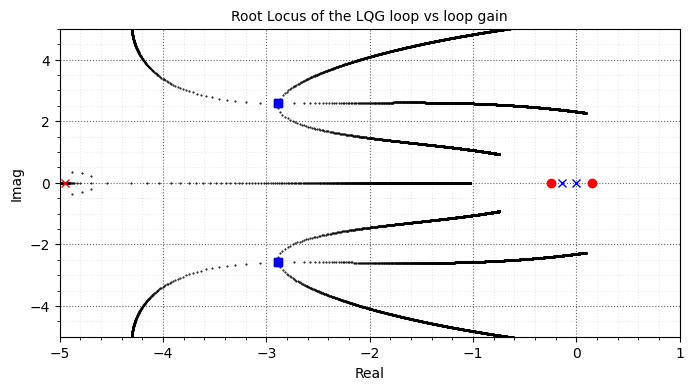

In [7]:
plt.figure(3,figsize=(8,4))
ax2 = plt.subplot(111)
rlist = control.root_locus(T_loop,kvect=np.linspace(1-delta,1+delta,num=5000),plot=False)
ax2.plot(rlist[0].real,rlist[0].imag,'k.',ms=1)
ax2.plot(P_cl.real,P_cl.imag,'bs',ms=6)
ax2.plot(P_s.real,P_s.imag,'bx',ms=6)
ax2.plot(P_comp.real,P_comp.imag,'rx',ms=6)
ax2.plot(Z_comp.real,Z_comp.imag,'ro',ms=6)
nicegrid(ax2)
ax2.set_xlim([-5,1])
ax2.set_ylim([-5,5])
plt.title('Root Locus of the LQG loop vs loop gain')
plt.xlabel('Real')
plt.ylabel('Imag')
plt.show()

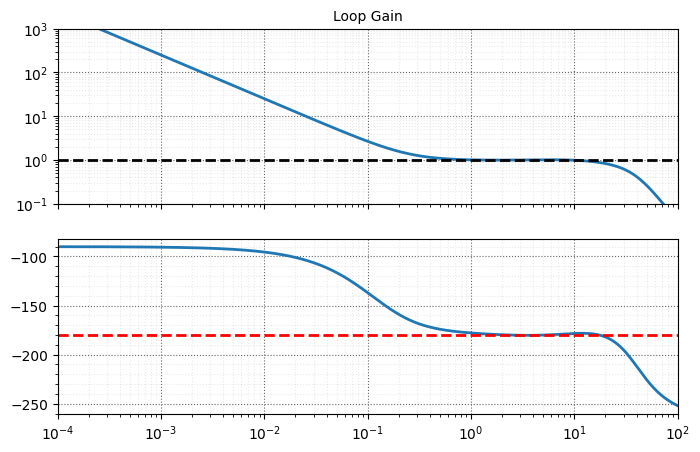

In [8]:
w = np.logspace(-5,2,1000)
mag,phase,omega = control.bode(T_loop,w,Hz=False,dB=False,deg=True,plot=False)

fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(8,5))
ax1.loglog(w,mag)                 # magnitude plot
ax1.semilogx([w[0],w[-1]],[1.,1.],'k--')                 # phase plot
ax1.set_title("Loop Gain")
ax1.set_xlim([.0001,100])
ax1.set_ylim([.1,1000])
nicegrid(ax1)

ax2.semilogx(w,phase*r2d)                 # phase plot
ax2.semilogx([w[0],w[-1]],[-180.,-180.],'r--')                 # phase plot
ax2.set_xlim([.0001,100])
nicegrid(ax2)

plt.show()

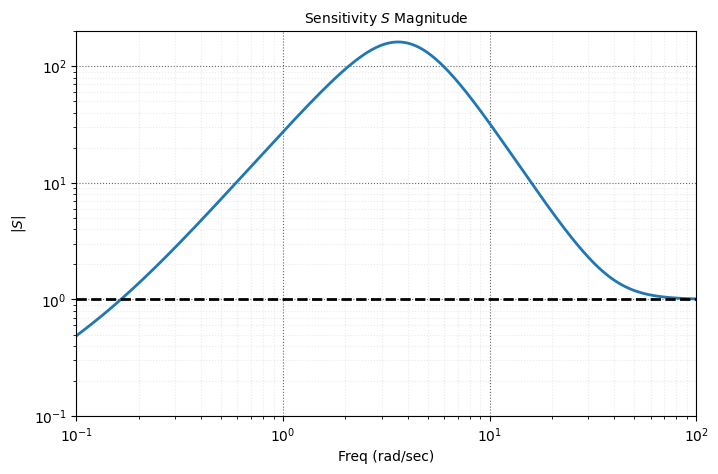

In [9]:
S = control.feedback(ss(0,0,0,1),sys_g*sys_comp)
mag,phase,omega = control.bode(S,w,Hz=False,dB=False,deg=True,plot=False)

fig, (ax1) = plt.subplots(1, sharex=True, figsize=(8,5))
plt.loglog(w,mag)
nicegrid()
plt.xlim([.1,100])
plt.ylim([.1,200])
plt.plot(plt.xlim(),[1,1],'k--')
plt.xlabel('Freq (rad/sec)')
plt.ylabel('$|S|$')
plt.title("Sensitivity $S$ Magnitude")
plt.show()

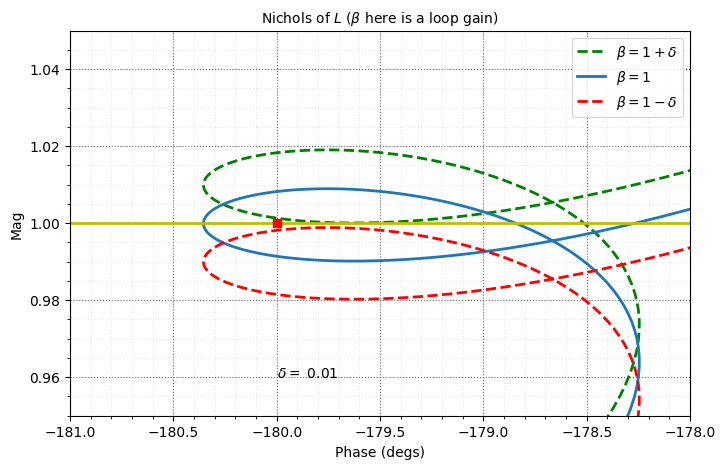

In [10]:
L_mag,L_phase,omega = control.bode(T_loop,w,Hz=False,dB=False,deg=True,plot=False)
fig, (ax1) = plt.subplots(1, sharex=True, figsize=(8,5))
plt.plot(L_phase*r2d,(1+delta)*L_mag,'g--',label=r'$\beta=1+\delta$')
plt.plot(L_phase*r2d,L_mag,label=r'$\beta=1$')
plt.plot(L_phase*r2d,(1-delta)*L_mag,'r--',label=r'$\beta=1-\delta$')
nicegrid()
plt.plot(plt.xlim(),[1,1],'y-')
plt.plot(-1*180,1,'rs')
plt.ylim([.95,1.05])
plt.xlim([-181,-178])
plt.text(-180,.96,f'$\delta = $ '+str(delta))
plt.xlabel('Phase (degs)')
plt.ylabel('Mag')
plt.title(r"Nichols of $L$ ($\beta$ here is a loop gain)")
plt.legend()
plt.show()

In [12]:
def f_lqr(t,xvec): # NL LQR
    theta, x, theta_dot, x_dot = xvec[0:nx]

    xpert = (xvec[0:nx] - np.array([np.pi,0.,0.,0.])).reshape(nx,1)
    u = -K @ xpert

    temp = np.linalg.inv(Mbar_NL(theta))@np.array([[-m*g*Ll*np.sin(theta)],[-b*x_dot + m*Ll*theta_dot**2*np.sin(theta) + u.item()]])
    xvec_dot = np.array([theta_dot, x_dot, temp[0][0].item(), temp[1][0].item()])
    return xvec_dot

def f_l_lqr(t,xvec): # Linear LQR
    xpert = (xvec[0:nx] - np.array([np.pi,0.,0.,0.])).reshape(nx,1)
    r = np.array([0.])
    u = - K @ xpert
    xvec_dot = A @ xpert + Bu*u
    return xvec_dot.reshape(1,nx)

def f_lqg(t,xvec): #NL LQG
    theta, x, theta_dot, x_dot = xvec[0:nx]
    e = - Cy@xvec[0:nx] # noise free for now
    xc = xvec[nx:2*nx]
    u = np.clip(Cc @ xc,-100,100)
    xc_dot = Ac@xc + (Bc*e).reshape(1,nx)
    result = np.array([xc_dot[0][:,i].item() for i in range(nx)]).flatten()
    temp = np.linalg.inv(Mbar_NL(theta))@np.array([[-m*g*Ll*np.sin(theta)],[-b*x_dot + m*Ll*theta_dot**2*np.sin(theta) + u.item()]])
    xvec_dot = [theta_dot, x_dot, temp[0][0].item(), temp[1][0], result[0], result[1], result[2], result[3]]
    return xvec_dot

def f_l_lqg(t,xvec): #Linear LQG
    xpert = (xvec[0:nx] - np.array([np.pi,0.,0.,0.]))
    e = - Cy@xpert # noise free for now
    u = np.clip(Cc @ xvec[nx:2*nx],-1000,1000)
    x_dot = np.squeeze(A@xpert + (Bu*u).reshape(1,nx))
    xc_dot = Ac@xvec[nx:2*nx] + Bc@e
    return [x_dot[0,0], x_dot[0,1], x_dot[0,2], x_dot[0,3], xc_dot[0,0], xc_dot[0,1], xc_dot[0,2], xc_dot[0,3]]

In [23]:
from scipy.integrate import solve_ivp
Tf = 5
Npts = 1000
t_plan = np.linspace(0, Tf, Npts) # MPC plan time

if 1:
    small_pert = True
else:
    small_pert = False

if small_pert:
    X0_lqg = np.array([np.pi*(0.975),0.002,0.,0.,0.,0.,0.,0.])
    X0_lqr = np.array([np.pi*(1.25),-0.5,0.,0.])
else:
    X0_lqg = np.array([np.pi*(0.95),0.002,0.,0.,0.,0.,0.,0.])
    X0_lqr = np.array([np.pi*(1.25),-0.5,0.,0.])

prop_lqg = solve_ivp(f_lqg, [0, Tf], X0_lqg, t_eval=t_plan)
prop_l_lqg = solve_ivp(f_l_lqg, [0, Tf], X0_lqg, t_eval=t_plan)

prop_lqr = solve_ivp(f_lqr, [0, Tf], X0_lqr, t_eval=t_plan)
prop_l_lqr = solve_ivp(f_l_lqr, [0, Tf], X0_lqr, t_eval=t_plan)

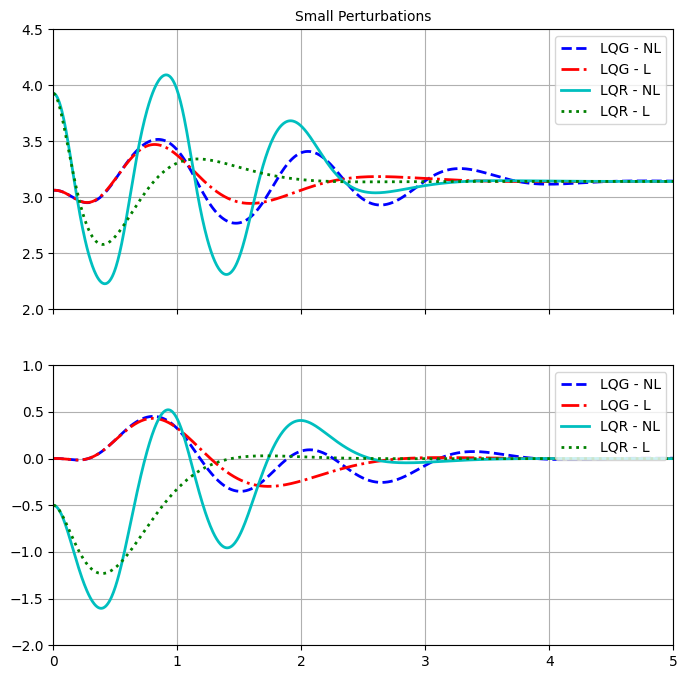

In [24]:
fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(8,8))
ax1.plot(prop_lqg.t,prop_lqg.y[0],'b--',label='LQG - NL')
ax1.plot(prop_l_lqg.t,prop_l_lqg.y[0],'r-.',label='LQG - L')
ax1.plot(prop_lqr.t,prop_lqr.y[0],'c',label='LQR - NL')
ax1.plot(prop_l_lqr.t,prop_l_lqr.y[0],'g:',label='LQR - L')
ax1.legend()
if small_pert:
    ax1.set_ylim(2,4.5)
    ax1.set_title('Small Perturbations')
else:
    ax1.set_ylim(-2,6)
    ax1.set_title('Large Perturbations')

ax2.plot(prop_lqg.t,prop_lqg.y[1],'b--',label='LQG - NL')
ax2.plot(prop_l_lqg.t,prop_l_lqg.y[1],'r-.',label='LQG - L')
ax2.plot(prop_lqr.t,prop_lqr.y[1],'c',label='LQR - NL')
ax2.plot(prop_l_lqr.t,prop_l_lqr.y[1],'g:',label='LQR - L')
ax2.set_xlim(0,Tf)
if small_pert:
    ax2.set_ylim(-2,1)
else:
    ax2.set_ylim(-3,3.5)  
ax2.legend(loc=1)
plt.show()